# CORD-19 Challenge

### Finding relevant research papers to transmission, incubation, and environmental stability of COVID-19

This notebook explores different approaches to finding relevant research papers to the transmission, incubation, and environmental stability of COVID-19. In this project, we used the provided COVID-19 Open Research Dataset containing 51k research papers related to COVID-19. We preprocess each document's title, abstract, and body sections by removing stop words, punctuations, and spaces. Lemmatization is also performed on each document to ensure all words are converted into its base form.

To find relevant documents to a given query, we explore two different approaches. In the first approach, we use term frequency and inverse document frequency to calculate the weight for each term in each document. The weights for each term is also calculated for the preprocessed query. We can then calculate the cosine similarity between each document and query and present the documents with the highest cosine similarities.

In the second approach, we use a large model with precalculated word embedding’s for biomedical data. Using the word embedding we can calculate the document vectors by simply averaging over the word vectors of the document. Using a similar approach, we can also calculate the vector for the preprocessed query. Given the query and document vectors, we can then calculate the cosine similarity between each document and query to find the relevant documents.




## Importing libraries

In [1]:
import pandas as pd
import os
import json
%matplotlib inline
from matplotlib import pyplot as plt
import scispacy
import spacy
import en_core_sci_lg
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Preparing the dataset

In [5]:
# read metadata file
df = pd.read_csv("./CORD-19-research-challenge/metadata.csv")
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,8q5ondtn,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(72)90077-4
1,pzfd0e50,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90355-5
2,22bka3gi,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701.0,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90356-7
3,zp9k1k3z,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/0002-9343(73)90176-9
4,cjuzul89,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-9343(85)90361-4


In [14]:
root_folder = "CORD-19-research-challenge"
#get full text
def get_full_text(paper):
    # defines which folder the research paper is in
    license = paper["full_text_file"]
    # used to build the path of the paper's json file
    if paper["has_pdf_parse"]:
        paper_type = "pdf_json"
        file_names = str(paper.sha).split("; ")
        suffix = ".json"
    elif paper["has_pmc_xml_parse"]:
        paper_type = "pmc_json"
        file_names = str(paper.pmcid).split("; ")
        suffix = ".xml.json"
    else:
        return ""
    # include the title in the full text
    full_text = [str(paper.title)]
    for file in file_names:
        file_path = os.path.join(root_folder, license, license, paper_type, file+suffix)
        with open(file_path) as json_file:
            data = json.load(json_file)
            # go through both the abstract and body_text sections of the json file
            for section in ["abstract", "body_text"]:
                if section in data:
                    for paragraph in data[section]:
                        full_text.append(paragraph["text"])
            
    return " ".join(full_text)


In [15]:
df['text'] = df.apply(lambda x: get_full_text(x), axis=1)
df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,text
0,8q5ondtn,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(72)90077-4,
1,pzfd0e50,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90355-5,
2,22bka3gi,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701.0,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-8703(80)90356-7,
3,zp9k1k3z,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/0002-9343(73)90176-9,Clinical and immunologic studies in identical ...
4,cjuzul89,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,False,custom_license,https://doi.org/10.1016/0002-9343(85)90361-4,


In [16]:
df.iloc[16188]["text"]

'Moderate mutation rate in the SARS coronavirus genome and its implications shows the phylogeny reconstructed using the neighboring-joining method with mid-point rooting. One striking feature is that GZ01 was distantly separated from other sequences. All the sequences from mainland China (GZ01 and BJ01-04) clustered together and separated from the remaining sequences. Interestingly, CUHK-W1 shared some common variants with those from mainland China, suggesting multiple sources of SARS-CoV in Hong Kong. A maximum parsimony tree was similar to that in Figure S1 . The phylogeny in Figure replicates. 2 Five Singaporean isolates (SIN2500, SIN2677, SIN2679, SIN2748, and SIN2774): SIN2500 was the primary index patient in Singapore and directly linked to index patient A in Hong Kong. SIN2677, SIN 2748, SIN2774, and SINxxxx (this patient was unavailable) were the four primary contacts and SIN2679 was the secondary contact of SINxxxx [9] . For those isolates, all patients have "history of close 

In [17]:
df.shape

(47298, 19)

## Preprocessing

In the preprocessing step, we first import the spacy biomedical model. We can then define a function to tokenize all words in a document or query. The function also performs lemmatization and removes common stop words.

In [18]:
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])

In [19]:
def tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [20]:
doc = tokenizer(df.iloc[16188]["text"])

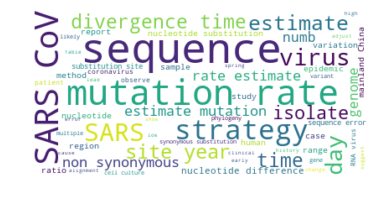

In [21]:
from wordcloud import WordCloud
# To visualize the word frequency of a document
wordcloud = WordCloud(max_font_size=50, max_words=60, background_color="white").generate(" ".join(doc))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Related documents with TF-IDF 

We have used TfidfVectorizer from sklearn to easily calculate TF-IDF vectors for each document and query. Cosine similarity is then computed between the query and each document to find the relevant documents.

In [23]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df[df.text != ""].text.to_numpy())

In [24]:
def get_related_documents_tfidf(query, vectorizer, doc_vectors, k):
    query_tokenized = tokenizer(query)
    query_vec = vectorizer.transform([" ".join(query_tokenized)])
    
    results = cosine_similarity(doc_vectors, query_vec)
    results = results.flatten()
    
    doc_indexes = np.argsort(results)[::-1]
    return df[df.text != ""].iloc[doc_indexes][:k]

In [28]:
query = "Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery."
get_related_documents_tfidf(query, vectorizer, vectors, 3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,text
22489,v6fistq1,4589d4013cf69c396e0fdb67131022fc11119654,PMC,Association between the Severity of Influenza ...,10.1371/journal.pone.0148506,PMC4757028,26885816.0,cc-by,"BACKGROUND: In early 2013, a novel avian-origi...",2016-02-17,"Virlogeux, Victor; Yang, Juan; Fang, Vicky J.;...",PLoS One,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,Association between the Severity of Influenza ...
22513,k8kgtzrx,68a2a48d4c67318b019928c9e1d1e896153a6cd2; b703...,PMC,Association between Severity of MERS-CoV Infec...,10.3201/eid2203.151437,PMC4766874,26890291.0,no-cc,We analyzed data for 170 patients in South Kor...,2016-03-03,"Virlogeux, Victor; Park, Minah; Wu, Joseph T.;...",Emerg Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,Association between Severity of MERS-CoV Infec...
46381,iicbaevw,31e1b495e358bdfb9ac295b4e1cdd8052056499d; 3862...,Elsevier,Incubation periods of acute respiratory viral ...,10.1016/s1473-3099(09)70069-6,PMC4327893,19393959.0,els-covid,Summary Knowledge of the incubation period is ...,2009-05-31,"Lessler, Justin; Reich, Nicholas G; Brookmeyer...",The Lancet Infectious Diseases,NaN,NaN,True,False,custom_license,https://doi.org/10.1016/s1473-3099(09)70069-6,Incubation periods of acute respiratory viral ...


## Related documents using word embeddings

In the word embedding approach, we used a large model for biomedical data from [scispacy](https://allenai.github.io/scispacy/).

In [29]:
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])

In [30]:
nlp.max_length = 10000000
def get_document_vectors(df):
    # all docs with text
    docs = df[df.text != ""]
    vectors = []
    for doc_index in range(len(docs)):
        doc = docs.iloc[doc_index]
        doc_text = doc.text
        doc_nlp = nlp(" ".join(tokenizer(doc_text)))
        vectors.append(doc_nlp.vector)
    return vectors

In [31]:
doc_vectors = get_document_vectors(df)

In [32]:
def get_related_documents_embeddings(query, doc_vectors, k):
    query_nlp = nlp(" ".join(tokenizer(query)))
    results = cosine_similarity(doc_vectors, query_nlp.vector.reshape(1,-1))
    results = results.flatten()

    doc_indexes = np.argsort(results)[::-1]
    return df[df.text != ""].iloc[doc_indexes][:k]
    

In [33]:
get_related_documents_embeddings(query,doc_vectors, 3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url,text
24886,gkvmjozy,9f63dea0f76ee477d2e8e5209d40179db431ab1d,PMC,"Estimating the incubation period of hand, foot...",10.1038/s41598-017-16705-7,PMC5705633,29184105.0,cc-by,"Hand, foot and mouth disease (HFMD) is a child...",2017-11-28,"Yang, Zhongzhou; Zhang, Qiqi; Cowling, Benjami...",Sci Rep,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,"Estimating the incubation period of hand, foot..."
22489,v6fistq1,4589d4013cf69c396e0fdb67131022fc11119654,PMC,Association between the Severity of Influenza ...,10.1371/journal.pone.0148506,PMC4757028,26885816.0,cc-by,"BACKGROUND: In early 2013, a novel avian-origi...",2016-02-17,"Virlogeux, Victor; Yang, Juan; Fang, Vicky J.;...",PLoS One,NaN,NaN,True,True,comm_use_subset,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,Association between the Severity of Influenza ...
46410,8anqfkmo,ce8609a60724d457d5b5916d57a31dea0ffb831b,PMC,The Incubation Period of Coronavirus Disease 2...,10.7326/m20-0504,PMC7081172,32150748.0,no-cc,"BACKGROUND: A novel human coronavirus, severe ...",2020-03-10,"Lauer, Stephen A.; Grantz, Kyra H.; Bi, Qifang...",Ann Intern Med,NaN,#5561,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,The Incubation Period of Coronavirus Disease 2...


## Results for all tasks

In this section, we output the top 3 documents relevant to each query given in the task using the 2 approaches described above.

In [34]:
queries = ["Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery",
          "Prevalence of asymptomatic shedding and transmission (e.g., particularly children)",
          "Seasonality of transmission",
          "Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding)",
          "Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood)",
          "Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic)",
          "Natural history of the virus and shedding of it from an infected person",
          "Implementation of diagnostics and products to improve clinical processes",
          "Disease models, including animal models for infection, disease and transmission",
          "Tools and studies to monitor phenotypic change and potential adaptation of the virus",
          "Immune response and immunity",
          "Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
          "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
          "Role of the environment in transmission"]

In [36]:
for i in queries:
    print(i)
    print(get_related_documents_tfidf(i, vectorizer, vectors, 3)[["title"]])
    print()

Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery
                                                   title
22489  Association between the Severity of Influenza ...
22513  Association between Severity of MERS-CoV Infec...
46381  Incubation periods of acute respiratory viral ...

Prevalence of asymptomatic shedding and transmission (e.g., particularly children)
                                                   title
11819  INFECTION CONTROL CHALLENGES IN CHILD-CARE CEN...
43998  Asymptomatic coronavirus infection: MERS-CoV a...
9105   Outbreak of coinfection with human metapneumov...

Seasonality of transmission
                                                   title
26354  The calendar of epidemics: Seasonal cycles of ...
28603  Long-term trends in seasonality of mortality i...
21227  Exploration of diarrhoea seasonality and its d...

Physical science of the coronavirus 

In [37]:
for i in queries:
    print(i)
    print(get_related_documents_embeddings(i,doc_vectors, 3)[["title"]])
    print()

Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery
                                                   title
24886  Estimating the incubation period of hand, foot...
22489  Association between the Severity of Influenza ...
46410  The Incubation Period of Coronavirus Disease 2...

Prevalence of asymptomatic shedding and transmission (e.g., particularly children)
                                                   title
2909   Chapter 17 Transmission of infectious diseases...
43998  Asymptomatic coronavirus infection: MERS-CoV a...
6135                           Breast milk and infection

Seasonality of transmission
                                                   title
26354  The calendar of epidemics: Seasonal cycles of ...
3135   7 Pretravel Considerations for Non-vaccine-Pre...
12427  Impact of global warming on viral diseases: wh...

Physical science of the coronavirus 

## Future Work

To improve the accuracy of the search results in the word embedding approach, we can use a larger model to better capture the representation of each word. We can also use the above two approaches to find the individual sentences or passages that answer each query.